# Land Cover Classification using Satellite Imagery and Unet Classifier
- End-to-end DL workflow with geosptial data

## Introduction

Land cover classification has been one of the most common tasks in many geospatial applications. 

The goal is to predict the land cover class (e.g. water, tree, building) for each pixel, unlike image classification in computer vision where we classify the entire input image as a whole.

__Study area__: Kent county, Delaware

__Input data__:
1. A one-meter resolution Color Infrared NAIP Imagery 
2. A labeled image that contains the class label for each pixel

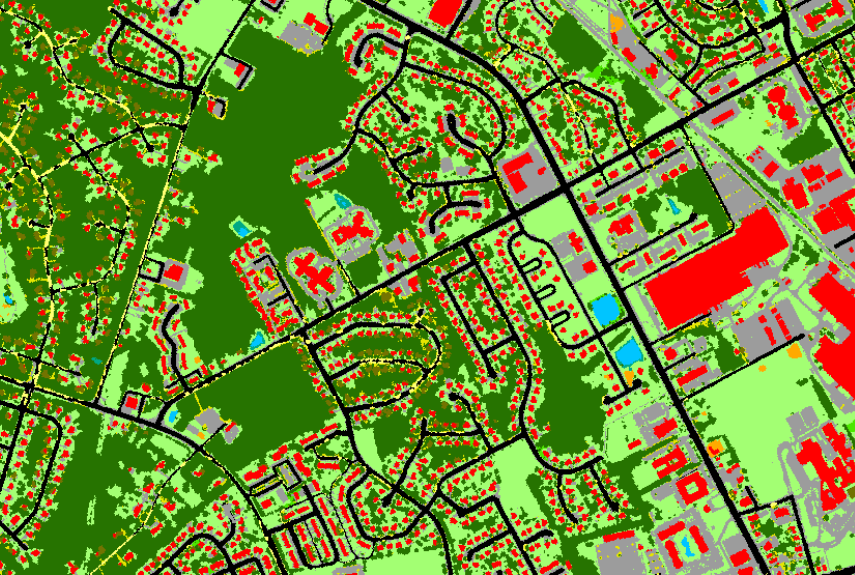
<center> Figure 1. A subset of of the labeled data for Kent county, Delaware

## Connect to your GIS

In [1]:
from arcgis import GIS

In [2]:
gis = GIS("home")

## Import data that will be used for training

<Item title:"USA NAIP Imagery: Color Infrared" type:Imagery Layer owner:esri_livingatlas>
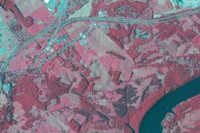

In [12]:
naip_item = gis.content.get('e4da3b6720f545aeaaf3fe8141da1e21') # NAIP imagery
naip_item

In [5]:
label_layer = gis.content.search("Kent_county_full_label_land_cover")[1] # Class label image for Kent county
label_layer

<Item title:"Kent_county_full_label_land_cover" type:Imagery Layer owner:portaladmin>

## Export training data using `arcgis.learn`

With the feature class and raster layer, we are now ready to export training data using the export_training_data() method in arcgis.learn module. In addtion to feature class, raster layer, and output folder, we also need to speficy a few other parameters such as tile_size (size of the image chips), strid_size (distance to move each time when creating the next image chip), chip_format (TIFF, PNG, or JPEG), metadata format (how we are going to store those training labels). More detail can be found [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). 

Depending on the size of your data, tile and stride size, and computing resources, this opertation can take 15mins~2hrs in our experiment. Also, do not re-run it if you already run it once unless you would like to update the setting.

In [18]:
import arcgis
from arcgis import learn
arcgis.env.verbose = True

In [ ]:
# divide the large input image (NAIP image) into subimages/chips
# generate a label image for each chip
export = learn.export_training_data(input_raster=naip_input_layer,
                                    output_location="landcover_sample",
                                    input_class_data=label_layer.url, 
                                    chip_format="PNG", 
                                    tile_size={"x":400,"y":400}, # size of each chip 
                                    stride_size={"x":0,"y":0}, 
                                    metadata_format="Classified_Tiles",                                        
                                    context={"startIndex": 0, "exportAllTiles": False, "cellSize": 2},
                                    context = context,
                                    gis = gis)

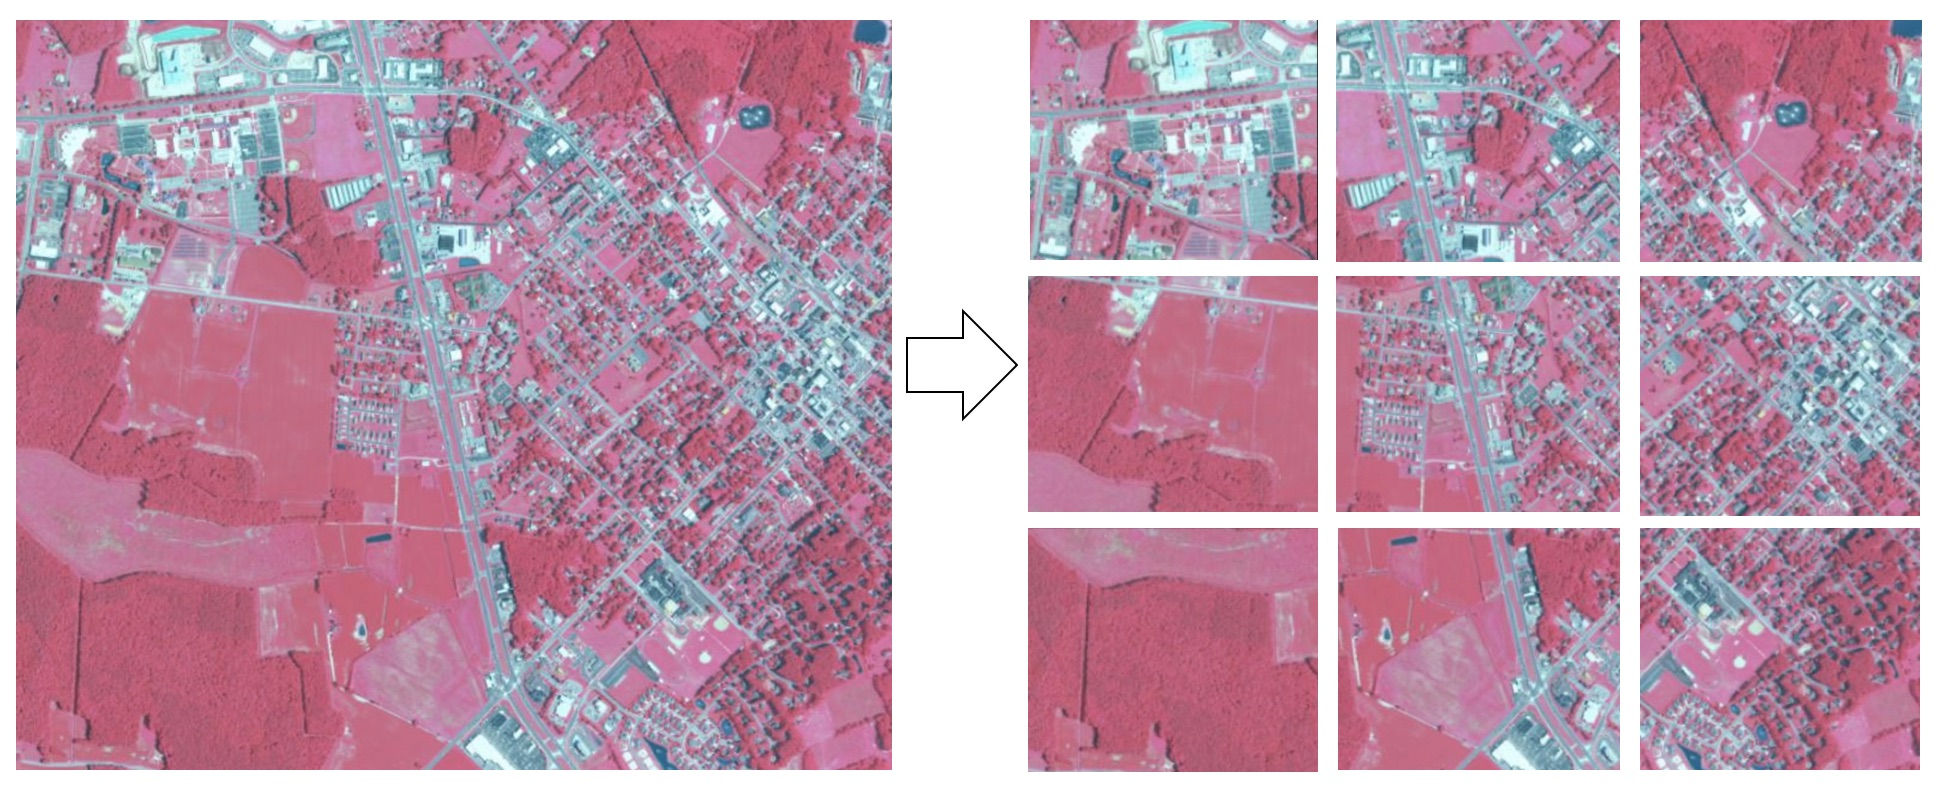

## Load training data

In [22]:
from arcgis.learn import UnetClassifier, prepare_data

In [24]:
# load it into memory and divide them into batches + data augmentation (e.g. flipping, rotating)
data_path = r'to_your_data_folder'
data = prepare_data(data_path, batch_size=16) 

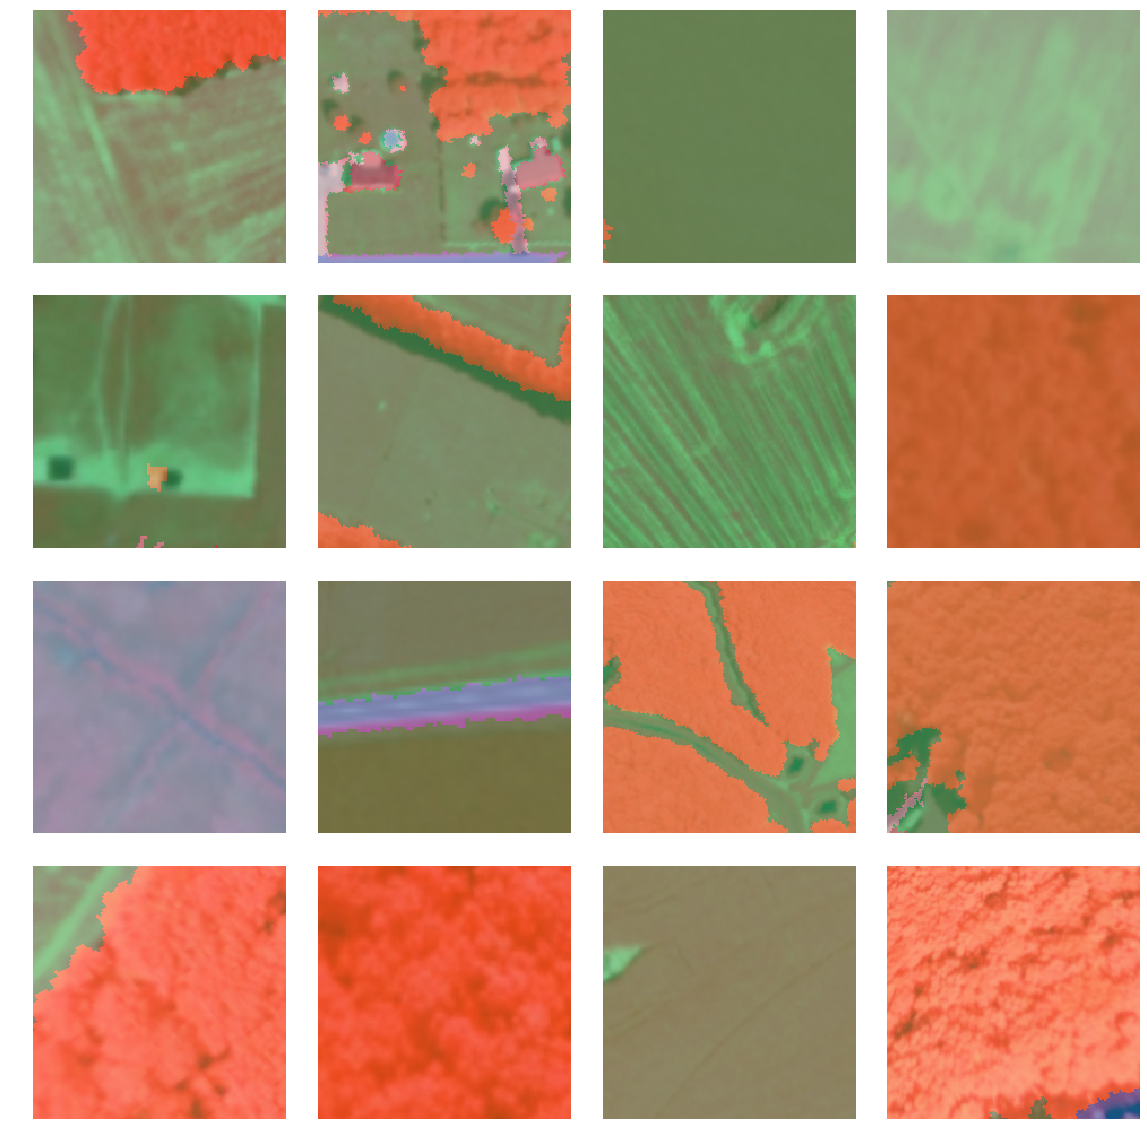

In [25]:
data.show_batch() # show a few random chips

## Load/define model architecture

Here we use U-net, a well-recognized image segmentation algorithm. The U-net architecture and a pretrained model has been predefined in `arcgis.learn`.

In [26]:
model = UnetClassifier(data)

Essentially a encoding CNN + decoding CNN + cross connection, which helps it make decision at various scales

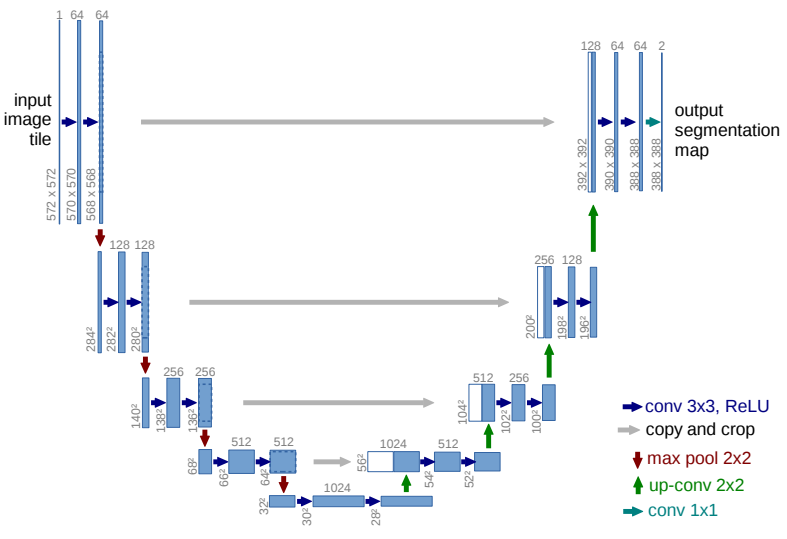
<center>Figure 2. Architecture of a Unet model [1]</center>

## Learning rate finder
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. We have a learning rate finder that helps you to choose a good value. It explores a range of learning rates to see where the loss is going down quickly.

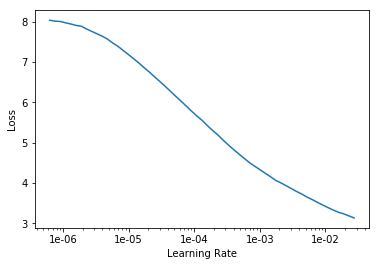

In [9]:
model.lr_find()

Based on the learning rate plot above, we can see that the loss going down dramatically at 1e-4, so it is what we will use for training.

## Model fitting

In [27]:
model.fit(10, lr=slice(1e-5, 1e-4)) # the first value is used to train the 1st few layers

epoch,train_loss,valid_loss,accuracy
1,0.488864,0.431946,0.873322
2,0.436592,0.362094,0.892988
3,0.358467,0.335168,0.899636
4,0.364898,0.321729,0.901571
5,0.351462,0.294477,0.906844
6,0.323483,0.288438,0.907954
7,0.317848,0.274222,0.912660
8,0.291879,0.286264,0.912971
9,0.284547,0.262629,0.915441
10,0.288180,0.260001,0.915736


## Visualize results in validation set
Now we have the model, let's look at how the model performs.

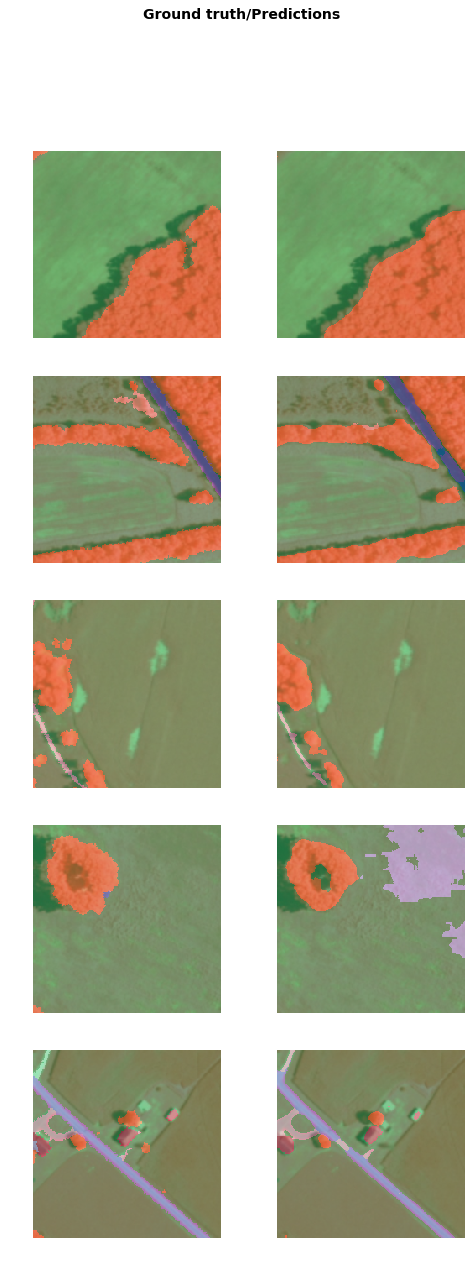

In [28]:
model.show_results()

## Deploy the model

Simply upload it to your enterprise portal as a deep learning package.

In [3]:
model_package = "Path_To_Your_Model_Package"

In [4]:
classify_land_model_package = gis.content.add(item_properties={"type":"Deep Learning Package",
                                                                "typeKeywords":"Deep Learning, Raster",
                                                                "title":"Land_Cover_Kent_DL_Model",
                                                                "tags":"deeplearning", 'overwrite':'True'}, 
                                              data=model_package)

In [5]:
classify_land_model_package

<Item title:"Land_Cover_Kent_DL_Model" type:Deep Learning Package owner:portaladmin>

## Model inference
Apply the model to a new image using `classify_pixels`. Pass in a spatial extent and you'll get back the classification result as a imagery layer.

In [33]:
from arcgis.learn import classify_pixels

ext = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': -8410906.74659668,
 'ymin': 4742638.69083856,
 'xmax': -8410520.95346634,
 'ymax': 4742953.91205481} # specify spatial extent of the new image

context = {'cellSize': 2,
          'processorType':'GPU',
          'extent': ext,
          'batch_size': 9}

In [34]:
out_classify = classify_pixels(input_raster=naiplayer,
                               model=land_cover_model,
                               output_name="land_cover_inference_test0",
                               context=context,
                               gis=gis)

out_classify

<Item title:"land_cover_inference_test0" type:Imagery Layer owner:portaladmin>

## Visualize classification result on map

In [ ]:
result_map = gis.map('Kent County, Delaware')
result_map.basemap ='satellite'


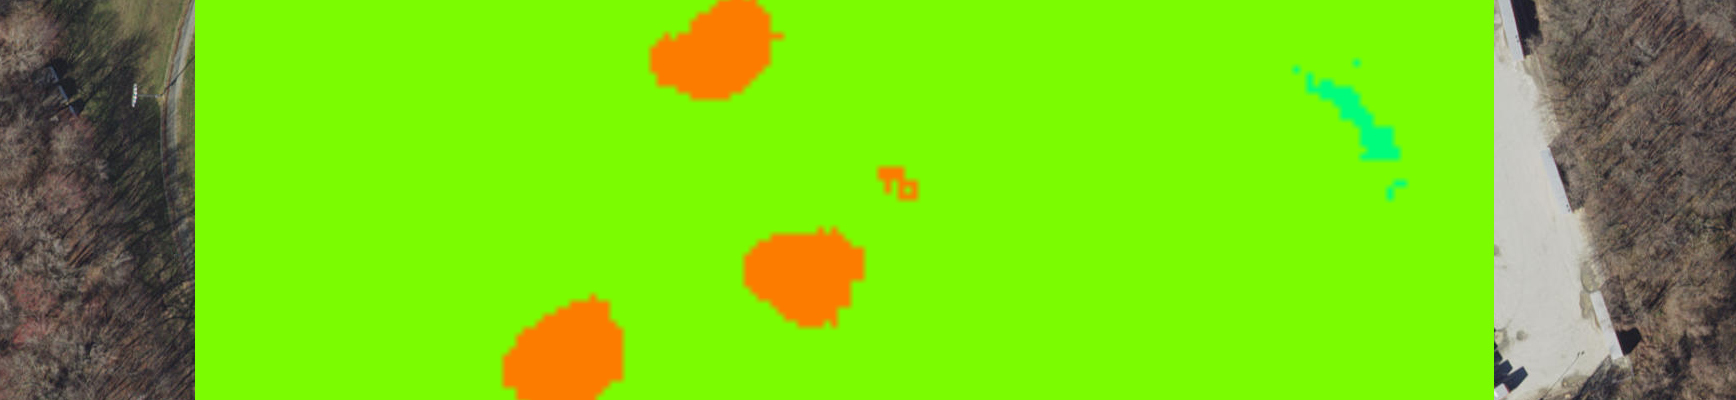

In [40]:
result_map.add_layer(colormap(out_classify.layers[0], astype='u8')) # applying color map [value, red, green, blue]
result_map

## Conclusion

`arcgis.learn` provides an end-to-end to land cover classification workflow, which has grealy simplified the DL workflow with geospatial data. As you might have noticed, we are following a similar pattern as those well-known ML libraries like scikit-learn: Load() -> fit() -> predict(), so it's easy to pick up if you have any previous ML programming experience.